In [111]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
import matplotlib
import datetime
from scipy.stats import norm
import imageio
from matplotlib.gridspec import GridSpec

from lib.analysis.laminar_dist import Line

# based on reference http://www.georgemather.com/Model.html#Refs

In [112]:
# an object moving in circles?
stim_type = ['circular_point',  # 0
             'single_pulse',    # 1
             'translating_bar', # 2
             'circular_edge',   # 3
             'double_pulse',    # 4
             'two_circular_points',     # 5
             'checkerboard_right'][6]   # 6

In [113]:
# intralaminar PV velocities over barrels of size 100-300 um
barrel_latency_PV = 200 / 57  # ms
barrel_latency_PV_se = 100 / 41
# Katherine S Scheuer, John M Judge, Xinyu Zhao, Meyer B Jackson, Velocity of conduction between columns and layers in barrel cortex reported by parvalbumin interneurons, Cerebral Cortex 33:17, 1 Sept 2023, p 9917–9926
print(barrel_latency_PV, barrel_latency_PV_se)

3.508771929824561 2.4390243902439024


In [114]:
barrel_latency_PV_excitatory_L4 = 1.028032
barrel_latency_PV_excitatory_L4_se = 1.0011922707332492

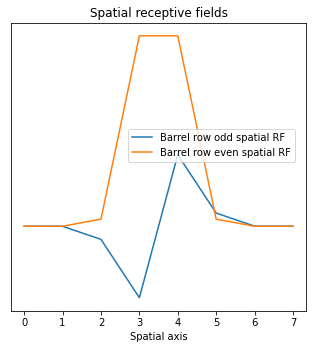

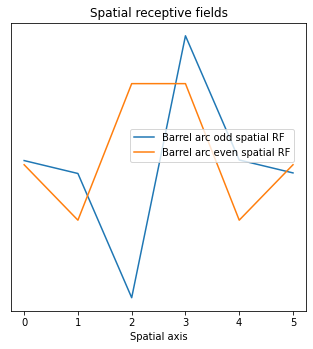

In [115]:
# Barrel cortex motion
# from http://www.georgemather.com/Model.html#Refs

# Define the space axis of the filters
nx_row = 8
ny_arc = 6
max_x = 0.2  # Half-width of filter (deg)
max_y = 0.2
dx = (max_x * 2) / nx_row  # Spatial sampling interval of filter (deg)
dy = (max_y * 2) / ny_arc

# A row vector holding spatial sampling intervals
x_filt = np.linspace(-max_x, max_x, nx_row)
y_filt = np.linspace(-max_y, max_y, ny_arc)

# Spatial filter parameters
sx = 0.05 # standard deviation of Gaussian, in deg.
sfx = 2.0 # spatial frequency of carrier, in cpd
sy = 0.11 # standard deviation of Gaussian, in deg.
sfy = 4.0 # spatial frequency of carrier, in cpd

# Spatial filter response
gauss_x = np.exp(-x_filt ** 2 / sx ** 2)  # Gaussian envelope
even_x = np.cos(2 * np.pi * sfx * x_filt) * gauss_x  # Even Gabor
odd_x = np.sin(2 * np.pi * sfx * x_filt) * gauss_x  # Odd Gabor
gauss_y = np.exp(-y_filt ** 2 / sy ** 2)  # Gaussian envelope
even_y = np.cos(2 * np.pi * sfy * y_filt) * gauss_y  # Even Gabor
odd_y = np.sin(2 * np.pi * sfy * y_filt) * gauss_y  # Odd Gabor

plt.plot(odd_x, label="Barrel row odd spatial RF")
plt.plot(even_x, label="Barrel row even spatial RF")
plt.xlabel("Spatial axis")
plt.title("Spatial receptive fields")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
plt.show()
plt.plot(odd_y, label="Barrel arc odd spatial RF")
plt.plot(even_y, label="Barrel arc even spatial RF")
plt.xlabel("Spatial axis")
plt.title("Spatial receptive fields")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
plt.show()

(0.0, 40.0)

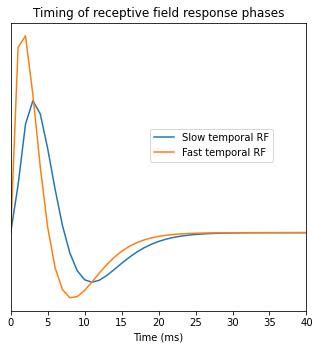

In [116]:
# Define the time axis of the filters
nt = 100  # number temporal samples in the filter
max_t = 0.5  # Duration of impulse response (sec)
dt = max_t / nt  #Temporal sampling interval (sec)

# temporal sampling intervals
t_filt = np.linspace(0, max_t, nt)

# Temporal filter parameters
k = 100 # Scales the response into time units
slow_n = 2 # Width of the slow temporal filter
fast_n = 1 # Width of the fast temporal filter
beta = 0.9 # Weighting of  -ve phase of the temporal resp relative to +ve phase.

# Temporal filter response
slow_t = (k * t_filt) ** slow_n * np.exp(-k * t_filt) * (1 / np.math.factorial(slow_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(slow_n + 2))
fast_t = (k * t_filt) ** fast_n * np.exp(-k * t_filt) * (1 / np.math.factorial(fast_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(fast_n + 2))

# To reflect casuality, have to reflect temporal component across t = 0
#slow_t = np.flip(slow_t)
#fast_t = np.flip(fast_t)

plt.plot(slow_t, label="Slow temporal RF")
plt.plot(fast_t, label="Fast temporal RF")
plt.xlabel("Time (ms)")
plt.title("Timing of receptive field response phases")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
#plt.annotate("EPSPs", xy=(5.08, 0.2))
#plt.annotate("IPSPs", xy=(10.08, -0.01))
ax = plt.gca()
ax.set_xlim([0, 40])




In [117]:
# spatiotemporal filters
# need all 2 x 2 x 2 = 8 combinations of t, x, y filters
# The orientation is controlled by the coupling of even and odd spatial functions
# Note that :
#       - Even is slightly more influential than odd function
#       - Fast function is slightly more influential than slow function
#       - "odd" is positive to the right first, and negative to the immediate left
#                Then in a few milliseconds, this switches.

# As an example, consider left_1 = o_fast + e_slow
#    Odd filter responds positively to signal that is high at the right
#    first, then high at the left next -- which is left-moving signal.
#    e_slow is smaller overall
# left_1 = -o_slow + e_fast
#    Odd portion is flipped, but smaller, so function is more positive to the right still

target_shape = (nt, nx_row, ny_arc)

# X-axis
e_slow_x = slow_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)  # SE/TS
e_slow_x = np.tile(e_slow_x.reshape(e_slow_x.shape + (1,)), (1, 1, ny_arc))

e_fast_x = fast_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)   # SE/TF
e_fast_x = np.tile(e_fast_x.reshape(e_fast_x.shape + (1,)), (1, 1, ny_arc))

o_slow_x = slow_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TS
o_slow_x = np.tile(o_slow_x.reshape(o_slow_x.shape + (1,)), (1, 1, ny_arc))

o_fast_x = fast_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TF
o_fast_x = np.tile(o_fast_x.reshape(o_fast_x.shape + (1,)), (1, 1, ny_arc))

# check accuracy in new dim
for a in [e_slow_x, e_fast_x, o_slow_x, o_fast_x]:
    for p in range(1, ny_arc):
        assert (a[:, :, 0] == a[:, :, p]).all()

# Y-axis
e_slow_y = slow_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_slow_y = np.tile(e_slow_y.reshape((e_slow_y.shape[0], 1, e_slow_y.shape[1])), (1, nx_row, 1))

e_fast_y = fast_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_fast_y = np.tile(e_fast_y.reshape((e_fast_y.shape[0], 1, e_fast_y.shape[1])), (1, nx_row, 1))

o_slow_y = slow_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_slow_y = np.tile(o_slow_y.reshape((o_slow_y.shape[0], 1, o_slow_y.shape[1])), (1, nx_row, 1))

o_fast_y = fast_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_fast_y = np.tile(o_fast_y.reshape((o_fast_y.shape[0], 1, o_fast_y.shape[1])), (1, nx_row, 1))

# check accuracy in new dim
for a in [e_slow_y, e_fast_y, o_slow_y, o_fast_y]:
    for p in range(1, nx_row):
        assert (a[:, 0, :] == a[:, p, :]).all()


# Spatiotemporally oriented filters of different components in each dim
left_1 = o_fast_x + e_slow_x  # L1_x
left_2 = -o_slow_x + e_fast_x  # L2_x
right_1 = -o_fast_x + e_slow_x  # R1_x
right_2 = o_slow_x + e_fast_x  # R2_x
down_1 = o_fast_y + e_slow_y  # L1_y
down_2 = -o_slow_y + e_fast_y  # L2_y
up_1 = -o_fast_y + e_slow_y  # R1_y
up_2 = o_slow_y + e_fast_y  # R2_y

#for im in [left_1_1, left_2_1, right_1_1, right_2_1,
#          left_1_2, left_2_2, right_1_2, right_2_2]:
    #print(im.shape)
    #plt.imshow(im[0,:,:])
    #ax = plt.gca()
    #ax.set_xlim([20, 60])
    #ax.set_ylim([0, 20])
    #plt.show()

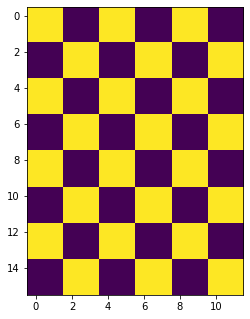

In [118]:
stim = np.zeros((120, nx_row * 2, ny_arc * 2))
if 'circular_point' in stim_type:
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_x = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + nx_row
        i_y = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + ny_arc
        #for i_x in range(6,9):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                stim[i_t, i_x+dx, i_y+dy] = 1
                if stim_type == 'two_circular_points':
                    stim[i_t, nx_row-(i_x+dx), i_y+dy] = 1
    
if stim_type == 'single_pulse':
    for i_t in range(50,54):
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
elif stim_type == "translating_bar":
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_y = int(5 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        for i_x in range(6,9):
            stim[i_t, i_y, i_x] = 1
elif stim_type == 'circular_edge':
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        y = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        x = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + 5
        #for i_x in range(6,9):
        ln = Line([8, 5], [y, x])
        for i_x in range(stim.shape[2]):
            for i_y in range(stim.shape[1]):
                if ln.is_point_left_of_line([i_y, i_x]):
                    stim[i_t, i_y, i_x] = 1
elif stim_type == 'double_pulse':
    onset = 30
    duration = 2  # ms
    IPI = 15
    onset1 = onset
    end1 = onset1 + duration * 2
    onset2 = onset1 + IPI
    end2 = onset2 + duration * 2
    for i_t in [g for g in range(onset1, end1)] + [g for g in range(onset2, end2)]:
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
elif stim_type == 'checkerboard_right':
    sq_sz = 2
    def create_checkerboard(w, h, square_size, centered_on, stim_arr, i_t):
        color = 1
        for i in range(centered_on[1], h, square_size):
            color *= -1
            ii = i % h
            # create one row at ii
            for j in range(centered_on[0], w, square_size):
                color *= -1
                for jj in range(square_size):
                    jjj = (jj + j) % w
                    if color > 0:
                        stim[i_t, jjj, ii] = 1
            # expand row to rest of rows in square size
            i_prev = ii
            for iii in range(1, square_size):
                i_f = (iii + i) % h
                stim[i_t, :, i_f] = stim[i_t, :, i_prev]
                if i_f < centered_on[1]:
                    stim[i_t, :, i_f] = 1 - stim[i_t, :, i_f]
                i_prev = i_f
                
        if i_t < 10:
            plt.imshow(stim_arr[i_t, :, :])
            plt.show()

    t, w, h = stim.shape
    create_checkerboard(w, h, sq_sz, (0, 0), stim, 0)
    for i_t in range(1, t):
        stim[i_t, :, :] = np.roll(stim[i_t-1, :, :], 1, axis=1)
        
                
# To reflect casuality, center the convolution properly (ORIGIN).
t_origin = -int(nt / 2)  # translate left, so that the PAST STIM determines the present response
# Rightward responses to stim
resp_right_1 = convolve(stim, right_1, mode='wrap', origin=(t_origin, 0, 0))
resp_right_2 = convolve(stim, right_2, mode='wrap', origin=(t_origin, 0, 0))

# Leftward responses
resp_left_1 = convolve(stim, left_1, mode='wrap', origin=(t_origin, 0, 0))
resp_left_2 = convolve(stim, left_2, mode='wrap', origin=(t_origin, 0, 0))

# upward responses
resp_up_1 = convolve(stim, up_1, mode='wrap', origin=(t_origin, 0, 0))
resp_up_2 = convolve(stim, up_2, mode='wrap', origin=(t_origin, 0, 0))

# downward responses
resp_down_1 = convolve(stim, down_1, mode='wrap', origin=(t_origin, 0, 0))
resp_down_2 = convolve(stim, down_2, mode='wrap', origin=(t_origin, 0, 0))

In [119]:
# square and normalize
resp_left_1 = resp_left_1 ** 2
resp_left_2 = resp_left_2  ** 2
resp_up_1 = resp_up_1 ** 2
resp_up_2 = resp_up_2  ** 2
resp_right_1 = resp_right_1 ** 2
resp_right_2 = resp_right_2 ** 2
resp_down_1 = resp_down_1 ** 2
resp_down_2 = resp_down_2 ** 2

# Calc left and right energy
energy_right = resp_right_1 + resp_right_2
energy_left = resp_left_1 + resp_left_2
energy_up = resp_up_1 + resp_up_2
energy_down = resp_down_1 + resp_down_2

# Calc total energy
total_energy_x = np.sum(energy_right)+np.sum(energy_left)
total_energy_y = np.sum(energy_down)+np.sum(energy_up)

# Normalise
RR1 = np.sum(resp_right_1) / total_energy_x
RR2 = np.sum(resp_right_2) / total_energy_x
LR1 = np.sum(resp_left_1) / total_energy_x
LR2 = np.sum(resp_left_2) / total_energy_x
UR1 = np.sum(resp_up_1) / total_energy_y
UR2 = np.sum(resp_up_2) / total_energy_y
DR1 = np.sum(resp_down_1) / total_energy_y
DR2 = np.sum(resp_down_2) / total_energy_y

# directional energy
right_Total = RR1 + RR2
left_Total = LR1 + LR2
up_Total = UR1 + UR2
down_Total = DR1 + DR2

# net motion energy
motion_energy_x = right_Total - left_Total
motion_energy_y = up_Total - down_Total
print('Net motion energy =', motion_energy_x, motion_energy_y)

Net motion energy = -1.3322676295501878e-15 -4.218847493575595e-15


In [120]:
# Generate motion contrast matrix
energy_opponent_x = energy_right - energy_left  # L-R difference matrix
energy_flicker_x = total_energy_x / (energy_left.shape[0] * energy_left.shape[1])  # A value for average total energy
energy_opponent_y = energy_up - energy_down
energy_flicker_y = total_energy_y / (energy_down.shape[0] * energy_down.shape[1])

# Re-scale L-R matrix using average energy.
motion_contrast_x = energy_opponent_x #/ energy_flicker_x
motion_contrast_y = energy_opponent_y #/ energy_flicker_y

# per frame
motion_contrast_per_frame_x = np.sum(motion_contrast_x, axis=(1,2))
motion_contrast_per_frame_y = np.sum(motion_contrast_y, axis=(1,2))

In [121]:
print("***************** Simulation summary *****************")
print("Stimulus")
print("\t ", stim_type)
print("Parameters")
print("\t X standard deviation of Gaussian, in deg. \t\tsx =", sx)
print("\t X spatial frequency of carrier, in cpd \t\tsfx =", sfx)
print("\t Y standard deviation of Gaussian, in deg. \t\tsy =", sy)
print("\t Width of the slow temporal filter \t\t\tslow_n =", slow_n)
print("\t Width of the fast temporal filter \t\t\tfast_n =", fast_n)
print("\t Weighting of -ve temp resp relative to +ve phase. \tbeta =", beta)
print("Standard deviation of energy")
print("\t X-std:", np.std(motion_contrast_per_frame_x))
print("\t Y-std:", np.std(motion_contrast_per_frame_y))
print("*******************************************************")

***************** Simulation summary *****************
Stimulus
	  checkerboard_right
Parameters
	 X standard deviation of Gaussian, in deg. 		sx = 0.05
	 X spatial frequency of carrier, in cpd 		sfx = 2.0
	 Y standard deviation of Gaussian, in deg. 		sy = 0.11
	 Width of the slow temporal filter 			slow_n = 2
	 Width of the fast temporal filter 			fast_n = 1
	 Weighting of -ve temp resp relative to +ve phase. 	beta = 0.9
Standard deviation of energy
	 X-std: 0.0
	 Y-std: 0.0
*******************************************************


-5.568878691519785e-13 -2.1449508835758024e-13


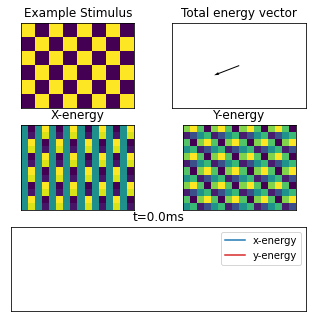

-5.568878691519785e-13 -2.1449508835758024e-13


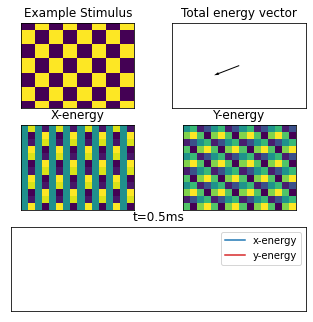

-5.568878691519785e-13 -2.1449508835758024e-13


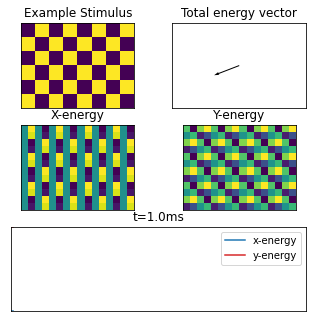

-5.568878691519785e-13 -2.1449508835758024e-13


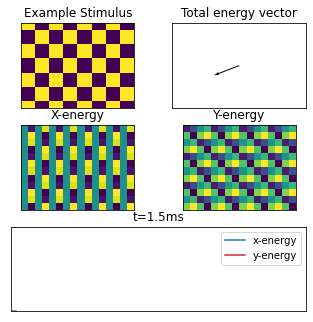

-5.568878691519785e-13 -2.1449508835758024e-13


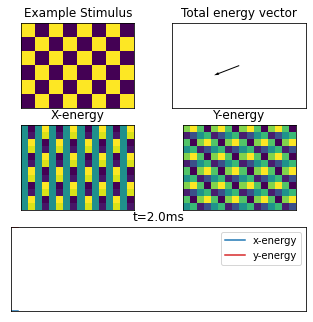

-5.568878691519785e-13 -2.1449508835758024e-13


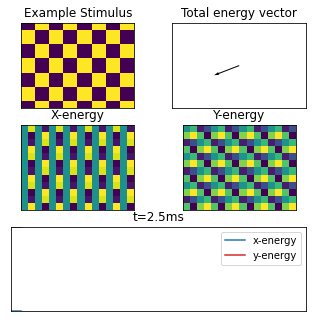

-5.568878691519785e-13 -2.1449508835758024e-13


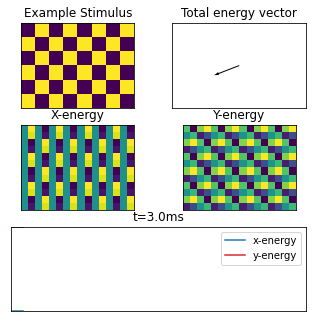

-5.568878691519785e-13 -2.1449508835758024e-13


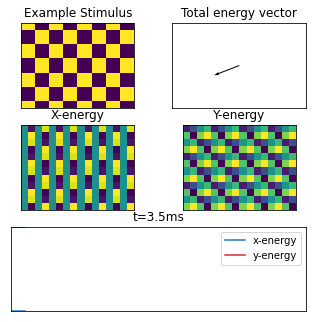

-5.568878691519785e-13 -2.1449508835758024e-13


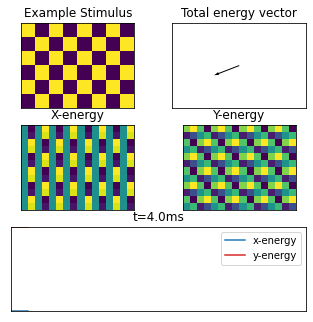

-5.568878691519785e-13 -2.1449508835758024e-13


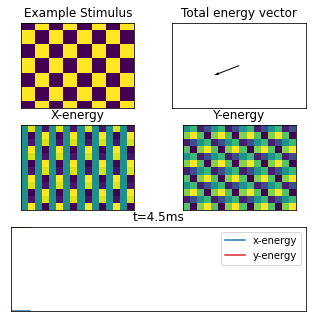

-5.568878691519785e-13 -2.1449508835758024e-13


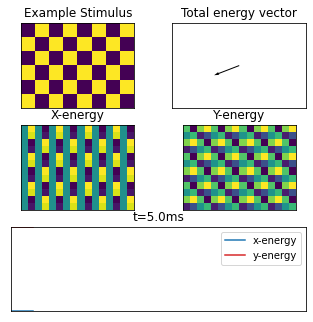

-5.568878691519785e-13 -2.1449508835758024e-13


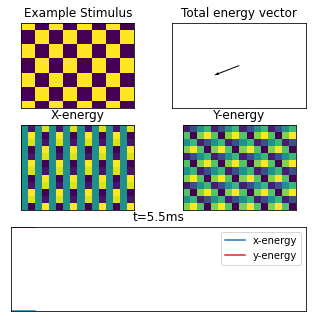

-5.568878691519785e-13 -2.1449508835758024e-13


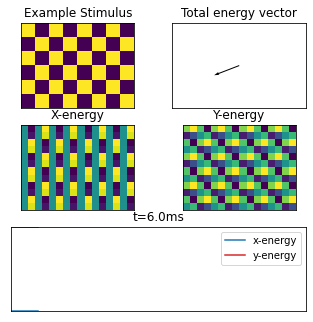

-5.568878691519785e-13 -2.1449508835758024e-13


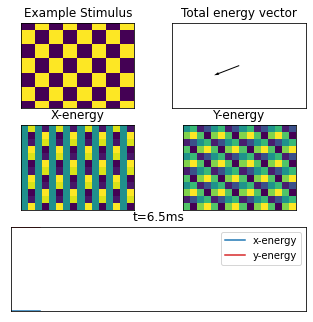

-5.568878691519785e-13 -2.1449508835758024e-13


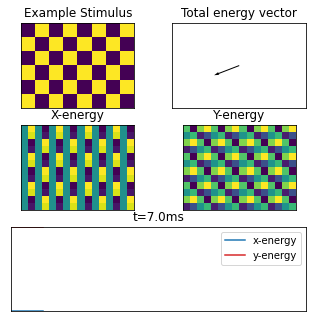

-5.568878691519785e-13 -2.1449508835758024e-13


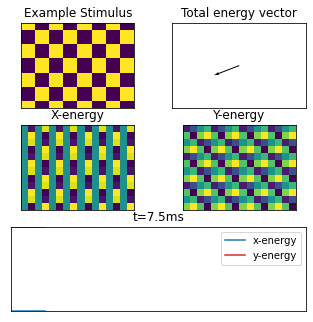

-5.568878691519785e-13 -2.1449508835758024e-13


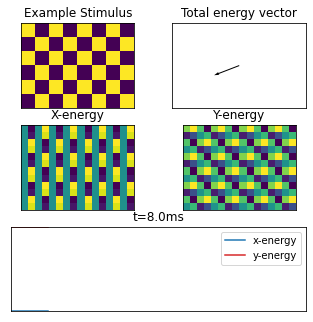

-5.568878691519785e-13 -2.1449508835758024e-13


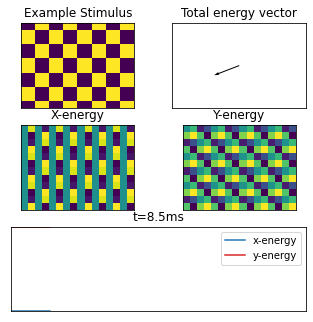

-5.568878691519785e-13 -2.1449508835758024e-13


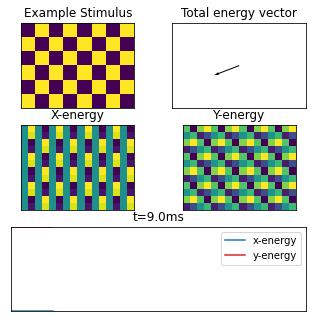

-5.568878691519785e-13 -2.1449508835758024e-13


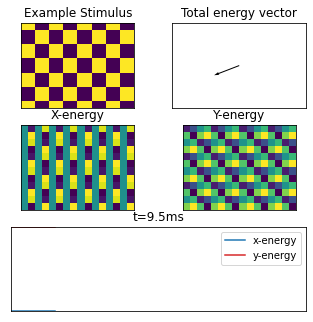

-5.568878691519785e-13 -2.1449508835758024e-13


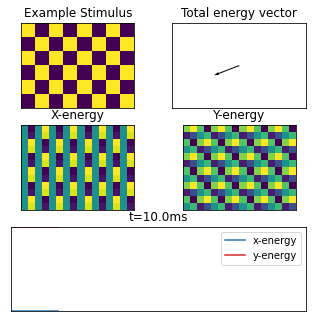

-5.568878691519785e-13 -2.1449508835758024e-13


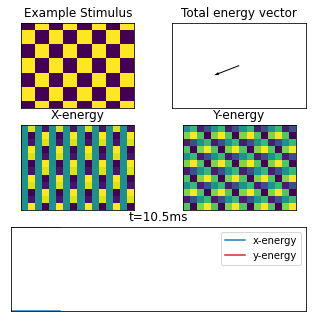

-5.568878691519785e-13 -2.1449508835758024e-13


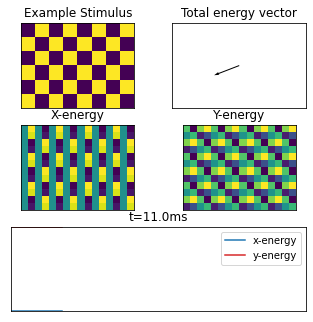

-5.568878691519785e-13 -2.1449508835758024e-13


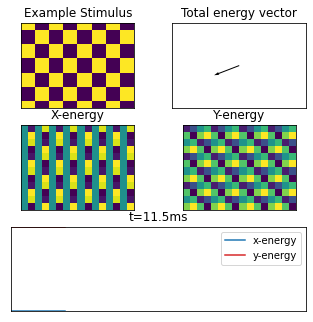

-5.568878691519785e-13 -2.1449508835758024e-13


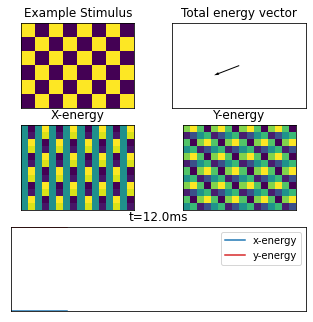

-5.568878691519785e-13 -2.1449508835758024e-13


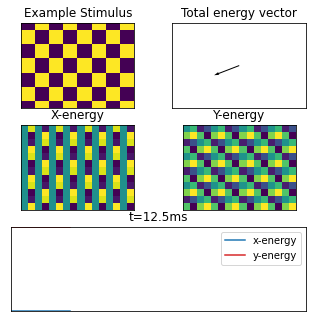

-5.568878691519785e-13 -2.1449508835758024e-13


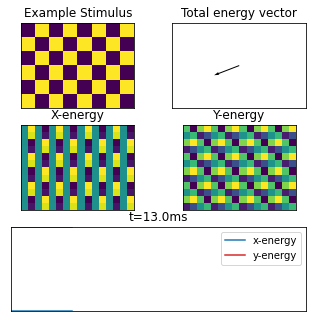

-5.568878691519785e-13 -2.1449508835758024e-13


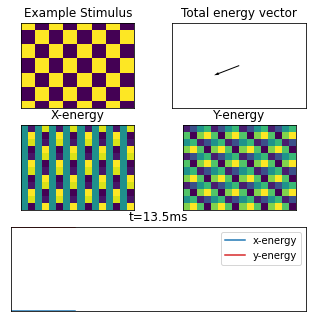

-5.568878691519785e-13 -2.1449508835758024e-13


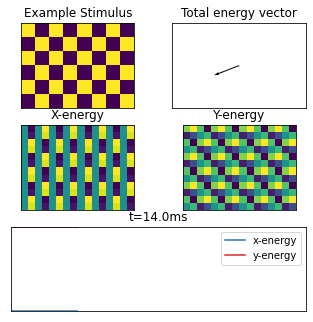

-5.568878691519785e-13 -2.1449508835758024e-13


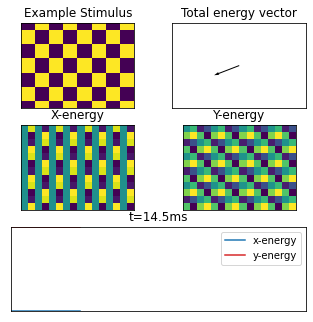

-5.568878691519785e-13 -2.1449508835758024e-13


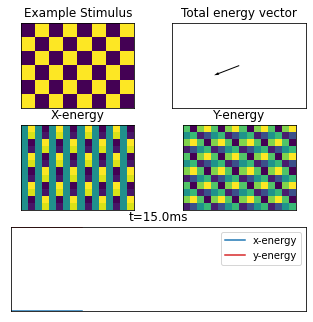

-5.568878691519785e-13 -2.1449508835758024e-13


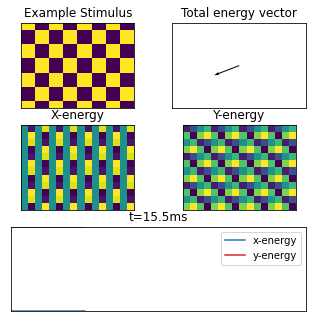

-5.568878691519785e-13 -2.1449508835758024e-13


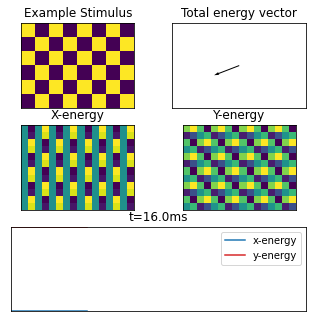

-5.568878691519785e-13 -2.1449508835758024e-13


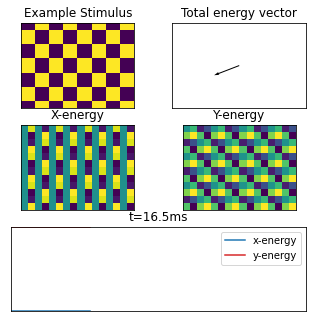

-5.568878691519785e-13 -2.1449508835758024e-13


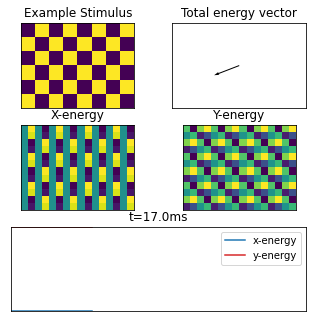

-5.568878691519785e-13 -2.1449508835758024e-13


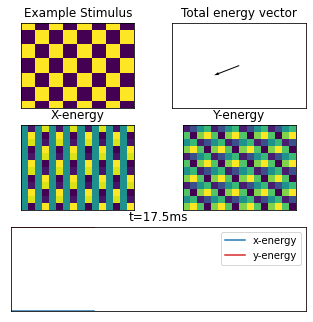

-5.568878691519785e-13 -2.1449508835758024e-13


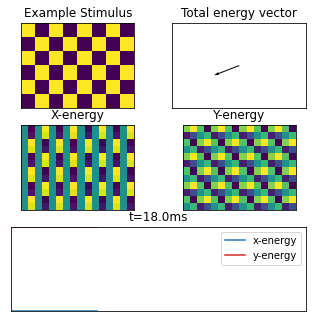

-5.568878691519785e-13 -2.1449508835758024e-13


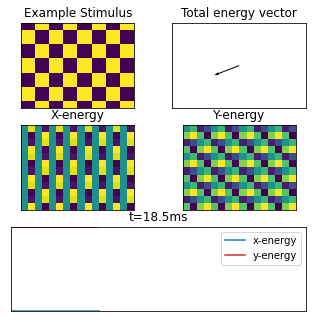

-5.568878691519785e-13 -2.1449508835758024e-13


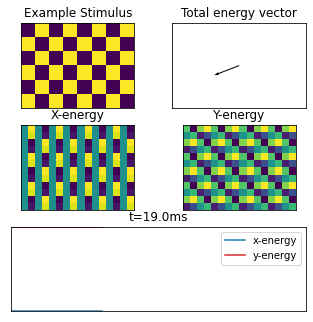

-5.568878691519785e-13 -2.1449508835758024e-13


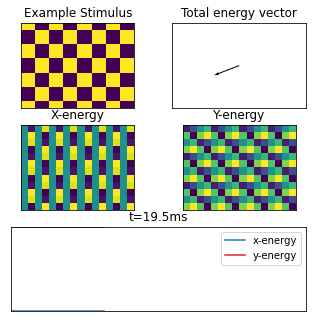

-5.568878691519785e-13 -2.1449508835758024e-13


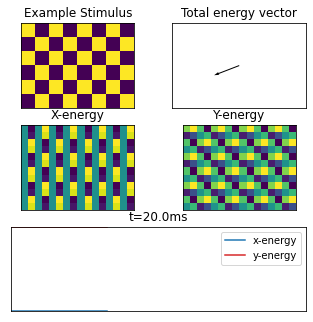

-5.568878691519785e-13 -2.1449508835758024e-13


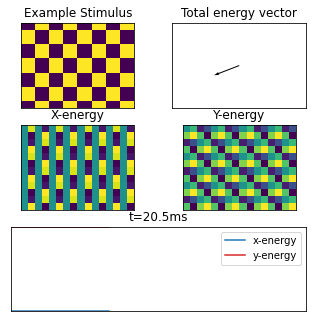

-5.568878691519785e-13 -2.1449508835758024e-13


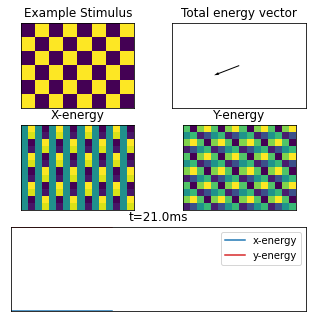

-5.568878691519785e-13 -2.1449508835758024e-13


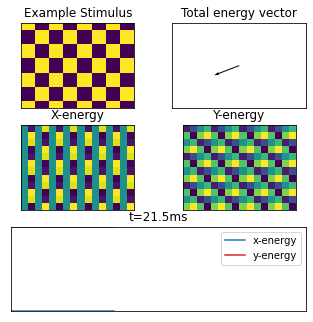

-5.568878691519785e-13 -2.1449508835758024e-13


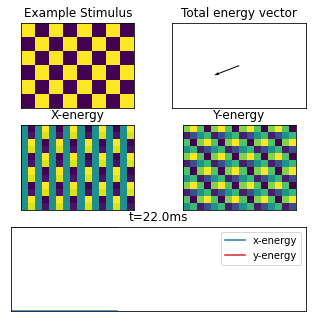

-5.568878691519785e-13 -2.1449508835758024e-13


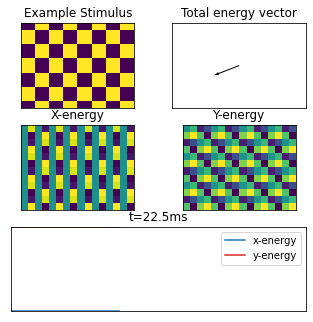

-5.568878691519785e-13 -2.1449508835758024e-13


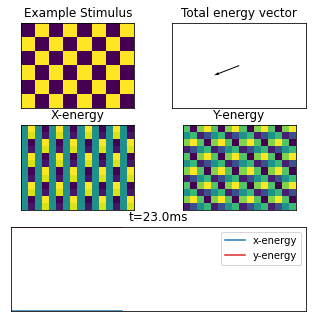

-5.568878691519785e-13 -2.1449508835758024e-13


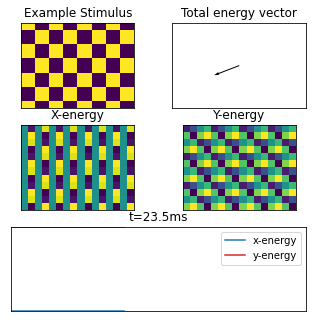

-5.568878691519785e-13 -2.1449508835758024e-13


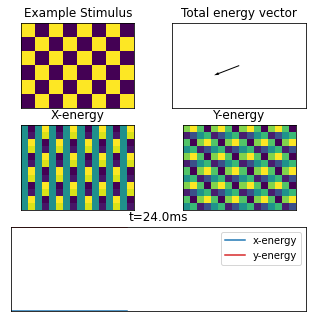

-5.568878691519785e-13 -2.1449508835758024e-13


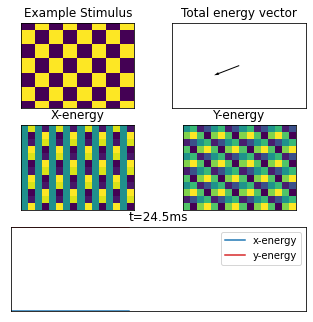

-5.568878691519785e-13 -2.1449508835758024e-13


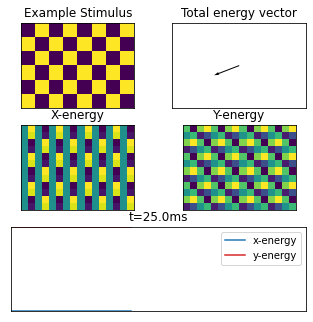

-5.568878691519785e-13 -2.1449508835758024e-13


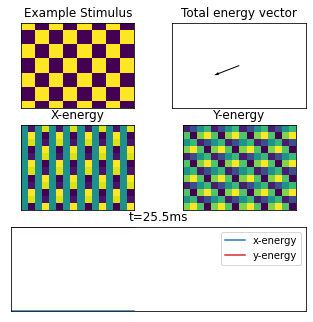

-5.568878691519785e-13 -2.1449508835758024e-13


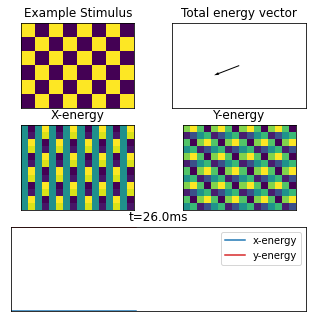

-5.568878691519785e-13 -2.1449508835758024e-13


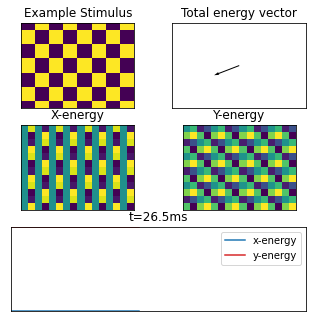

-5.568878691519785e-13 -2.1449508835758024e-13


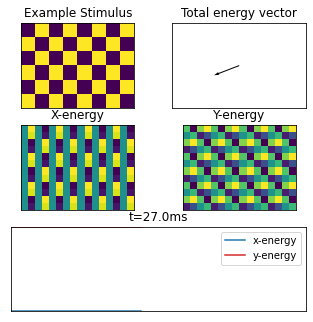

-5.568878691519785e-13 -2.1449508835758024e-13


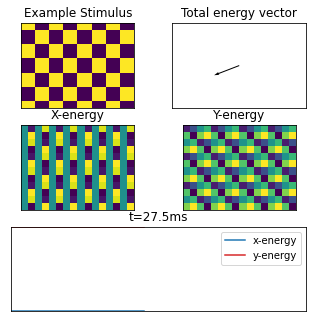

-5.568878691519785e-13 -2.1449508835758024e-13


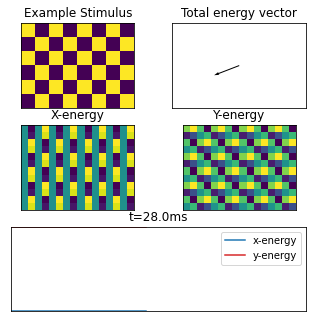

-5.568878691519785e-13 -2.1449508835758024e-13


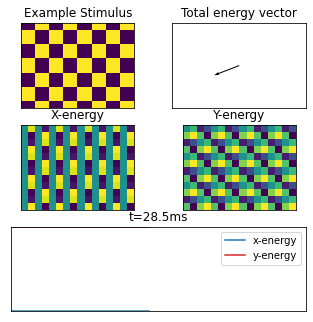

-5.568878691519785e-13 -2.1449508835758024e-13


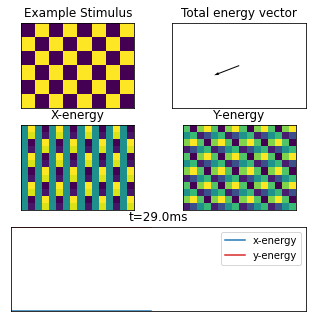

-5.568878691519785e-13 -2.1449508835758024e-13


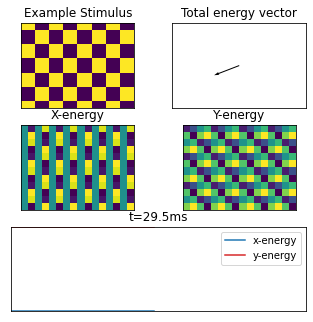

-5.568878691519785e-13 -2.1449508835758024e-13


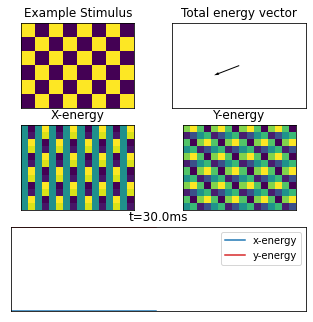

-5.568878691519785e-13 -2.1449508835758024e-13


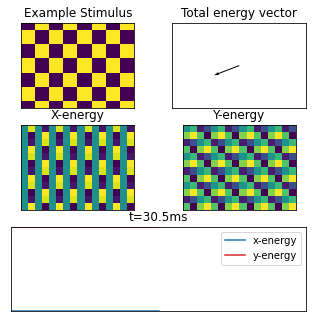

-5.568878691519785e-13 -2.1449508835758024e-13


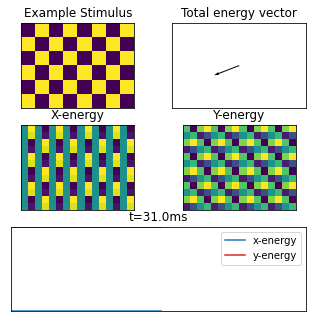

-5.568878691519785e-13 -2.1449508835758024e-13


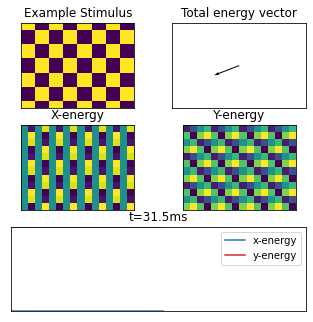

-5.568878691519785e-13 -2.1449508835758024e-13


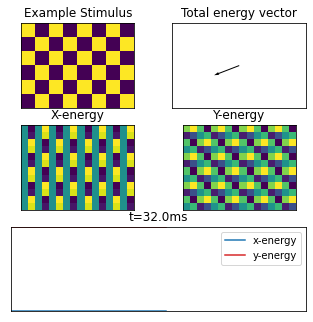

-5.568878691519785e-13 -2.1449508835758024e-13


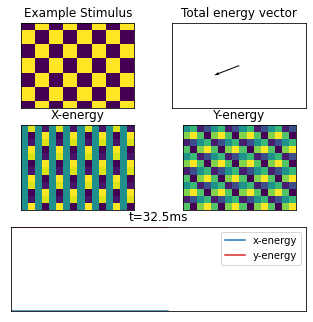

-5.568878691519785e-13 -2.1449508835758024e-13


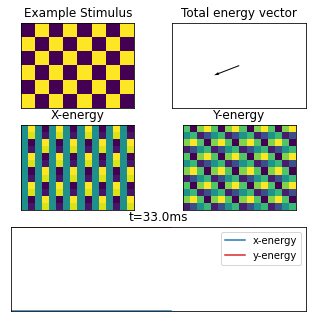

-5.568878691519785e-13 -2.1449508835758024e-13


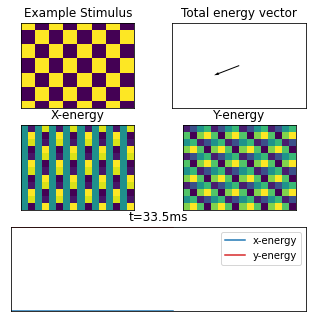

-5.568878691519785e-13 -2.1449508835758024e-13


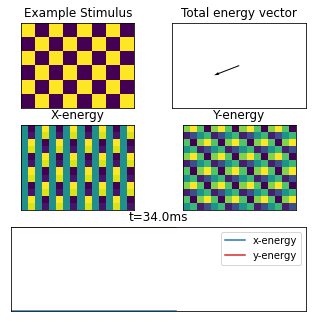

-5.568878691519785e-13 -2.1449508835758024e-13


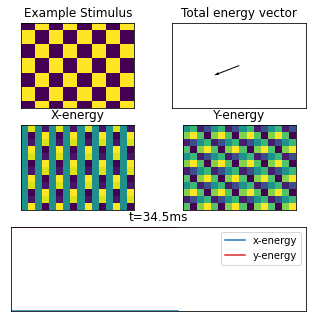

-5.568878691519785e-13 -2.1449508835758024e-13


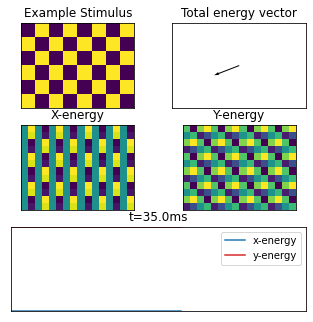

-5.568878691519785e-13 -2.1449508835758024e-13


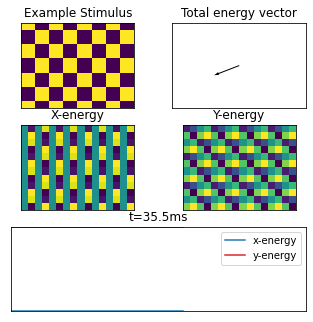

-5.568878691519785e-13 -2.1449508835758024e-13


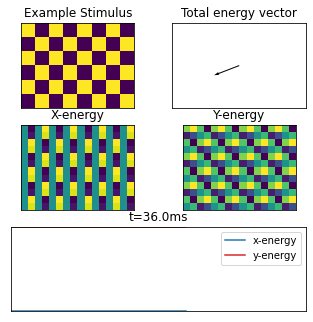

-5.568878691519785e-13 -2.1449508835758024e-13


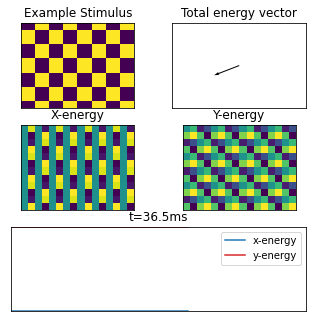

-5.568878691519785e-13 -2.1449508835758024e-13


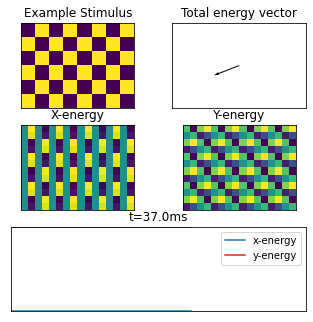

-5.568878691519785e-13 -2.1449508835758024e-13


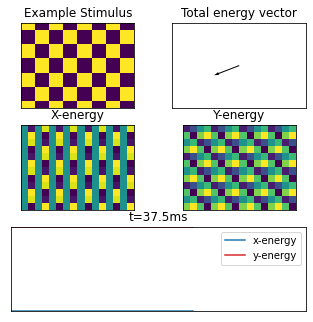

-5.568878691519785e-13 -2.1449508835758024e-13


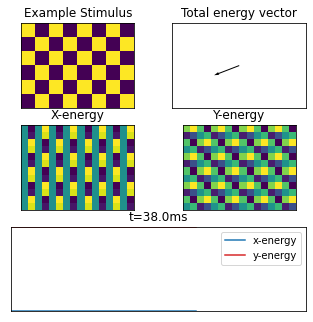

-5.568878691519785e-13 -2.1449508835758024e-13


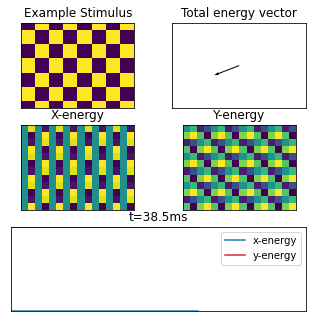

-5.568878691519785e-13 -2.1449508835758024e-13


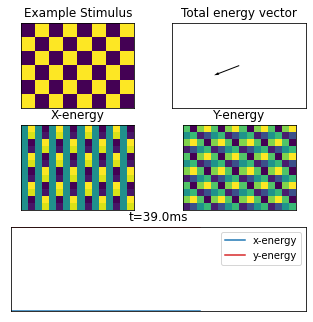

-5.568878691519785e-13 -2.1449508835758024e-13


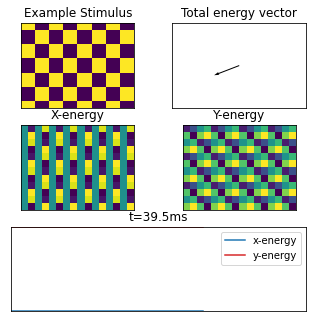

-5.568878691519785e-13 -2.1449508835758024e-13


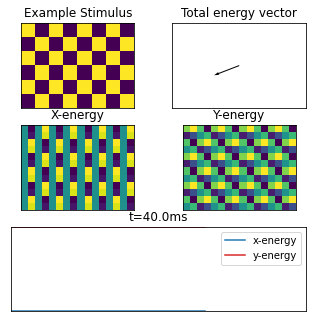

-5.568878691519785e-13 -2.1449508835758024e-13


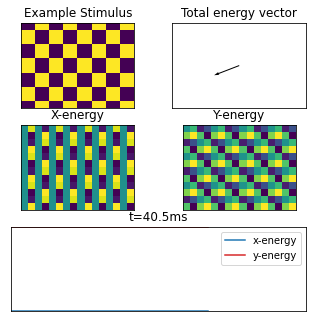

-5.568878691519785e-13 -2.1449508835758024e-13


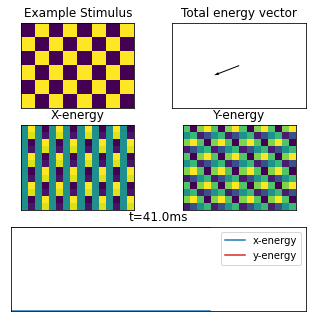

-5.568878691519785e-13 -2.1449508835758024e-13


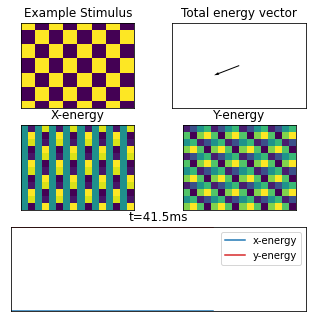

-5.568878691519785e-13 -2.1449508835758024e-13


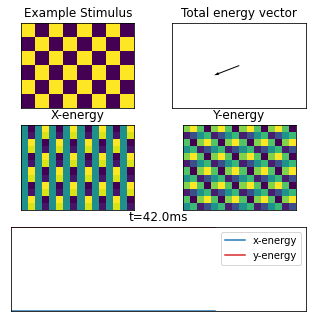

-5.568878691519785e-13 -2.1449508835758024e-13


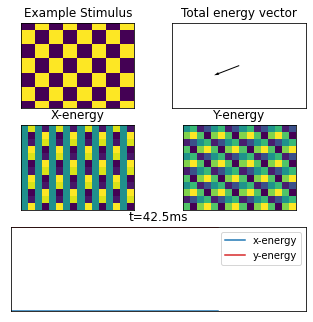

-5.568878691519785e-13 -2.1449508835758024e-13


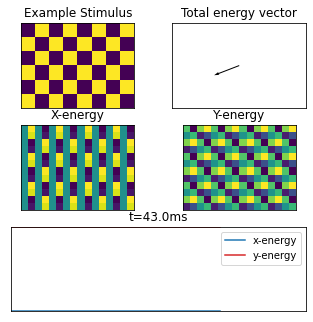

-5.568878691519785e-13 -2.1449508835758024e-13


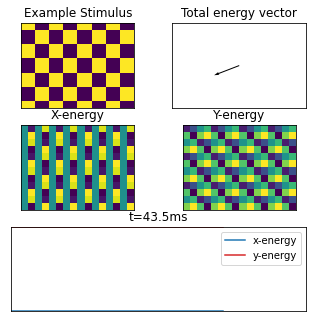

-5.568878691519785e-13 -2.1449508835758024e-13


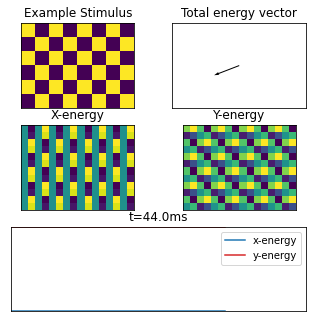

-5.568878691519785e-13 -2.1449508835758024e-13


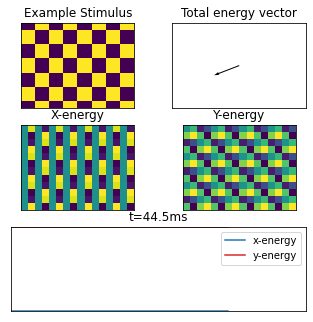

-5.568878691519785e-13 -2.1449508835758024e-13


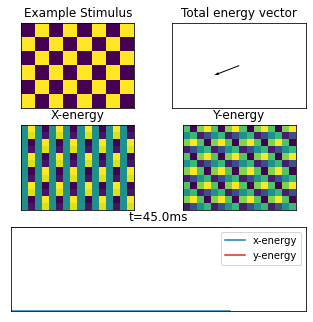

-5.568878691519785e-13 -2.1449508835758024e-13


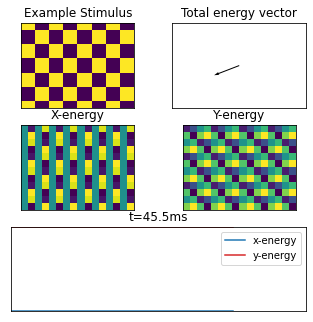

-5.568878691519785e-13 -2.1449508835758024e-13


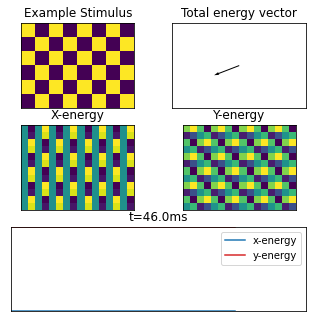

-5.568878691519785e-13 -2.1449508835758024e-13


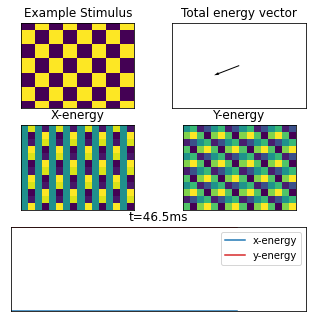

-5.568878691519785e-13 -2.1449508835758024e-13


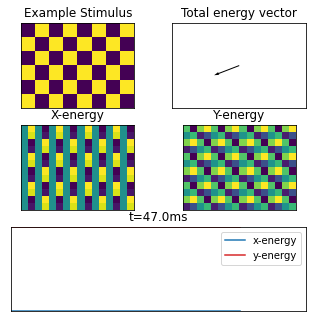

-5.568878691519785e-13 -2.1449508835758024e-13


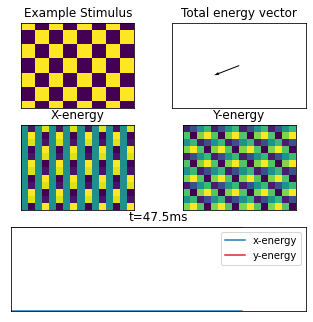

-5.568878691519785e-13 -2.1449508835758024e-13


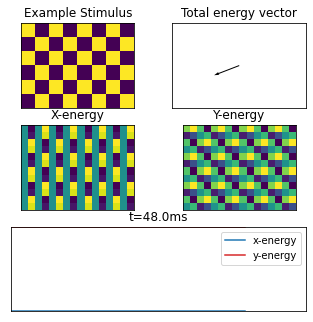

-5.568878691519785e-13 -2.1449508835758024e-13


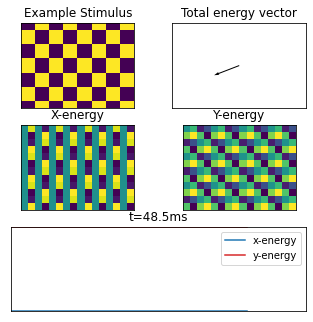

-5.568878691519785e-13 -2.1449508835758024e-13


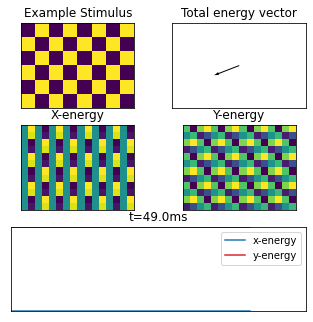

-5.568878691519785e-13 -2.1449508835758024e-13


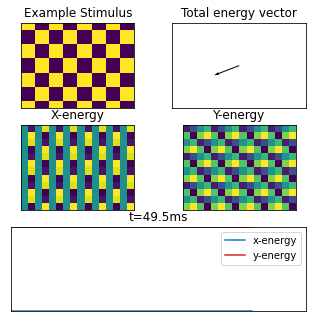

-5.568878691519785e-13 -2.1449508835758024e-13


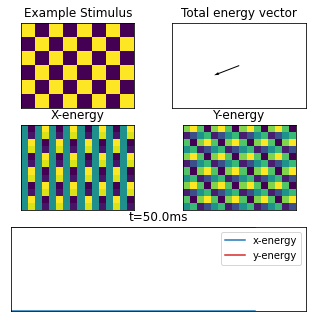

-5.568878691519785e-13 -2.1449508835758024e-13


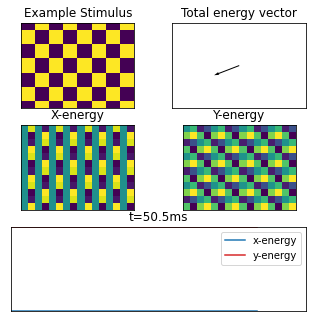

-5.568878691519785e-13 -2.1449508835758024e-13


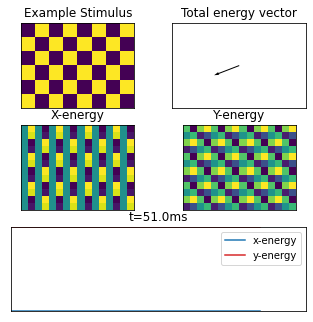

-5.568878691519785e-13 -2.1449508835758024e-13


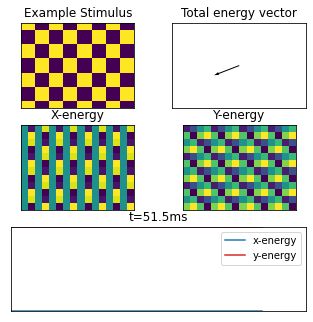

-5.568878691519785e-13 -2.1449508835758024e-13


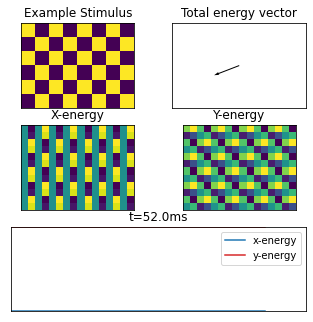

-5.568878691519785e-13 -2.1449508835758024e-13


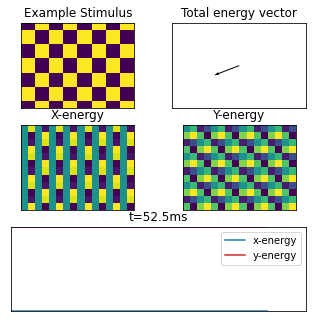

-5.568878691519785e-13 -2.1449508835758024e-13


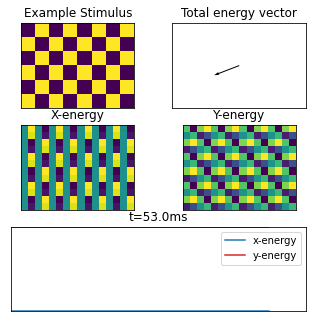

-5.568878691519785e-13 -2.1449508835758024e-13


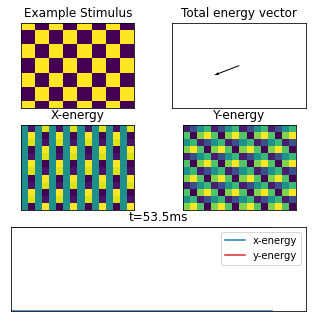

-5.568878691519785e-13 -2.1449508835758024e-13


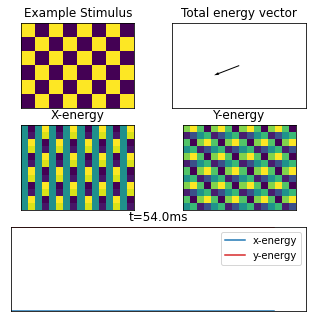

-5.568878691519785e-13 -2.1449508835758024e-13


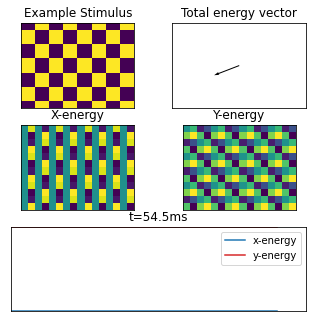

-5.568878691519785e-13 -2.1449508835758024e-13


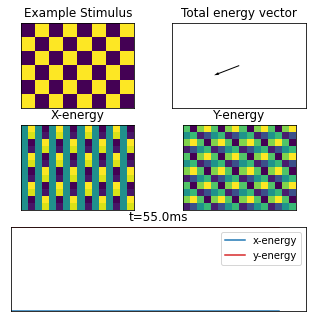

-5.568878691519785e-13 -2.1449508835758024e-13


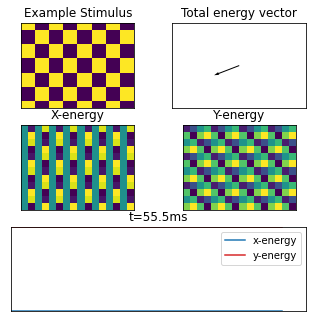

-5.568878691519785e-13 -2.1449508835758024e-13


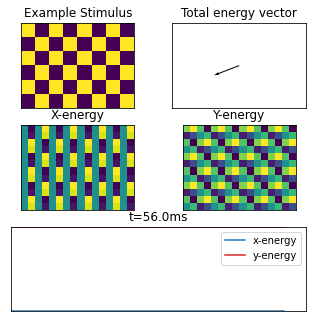

-5.568878691519785e-13 -2.1449508835758024e-13


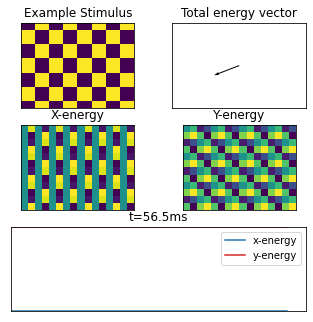

-5.568878691519785e-13 -2.1449508835758024e-13


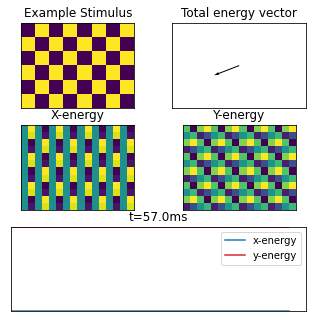

-5.568878691519785e-13 -2.1449508835758024e-13


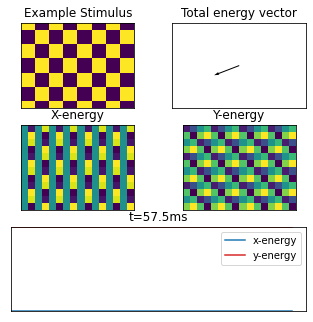

-5.568878691519785e-13 -2.1449508835758024e-13


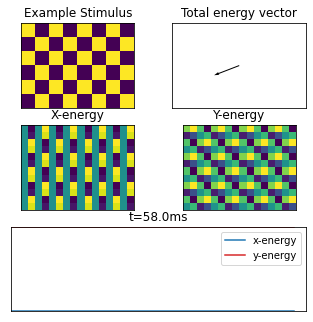

-5.568878691519785e-13 -2.1449508835758024e-13


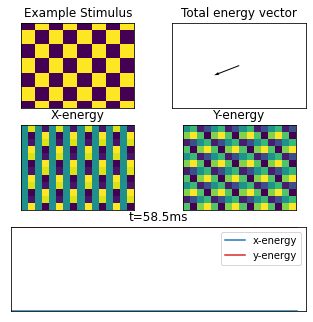

-5.568878691519785e-13 -2.1449508835758024e-13


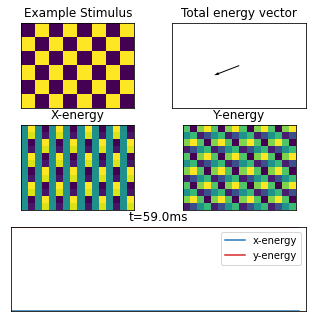

-5.568878691519785e-13 -2.1449508835758024e-13


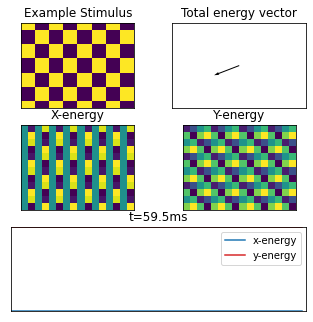

In [122]:
combined_img_files = []
process_combined = True
step_size = 1
x_energy_min = np.min(motion_contrast_x)
x_energy_max = np.max(motion_contrast_x)
y_energy_min = np.min(motion_contrast_y)
y_energy_max = np.max(motion_contrast_y)
matplotlib.rc ('figure', figsize= (5.3, 5.3))

for i in range(0, stim.shape[0], step_size):
        
    fig = plt.figure()
    gs = GridSpec(3, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[2,:])
    dir_ax = fig.add_subplot(gs[0,1])
    ax_y_energy = fig.add_subplot(gs[1,1])
    
    ax0.imshow(np.transpose(stim)[:,:,i])
    ax0.set_title("Example Stimulus")
    ax0.set_yticks([])
    ax0.set_xticks([])
    ax1.imshow(np.transpose(motion_contrast_x)[:,:,i],
               vmin=x_energy_min,
               vmax=x_energy_max)
    ax1.set_title("X-energy")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax_y_energy.imshow(np.transpose(motion_contrast_y)[:,:,i],
                       vmin=y_energy_min,
                       vmax=y_energy_max)
    ax_y_energy.set_title("Y-energy")
    ax_y_energy.set_yticks([])
    ax_y_energy.set_xticks([])
    
    ax2.plot(motion_contrast_per_frame_x[:i], color='tab:blue', label="x-energy")
    ax2.plot(motion_contrast_per_frame_y[:i], color='tab:red', label="y-energy")
    ax2.axhline(y=0.0, color='black', linestyle='--')
    ax2.set_xlim([0, motion_contrast_per_frame_x.shape[0]])
    y_max = max(np.max(motion_contrast_per_frame_x), np.max(motion_contrast_per_frame_y))
    y_min = min(np.min(motion_contrast_per_frame_x), np.min(motion_contrast_per_frame_y))
    ax2.set_ylim([y_min, y_max])
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title("t="+str(i/2)+"ms")
    ax2.legend(loc='upper right')
    
    dir_ax.set_title("Total energy vector")
    dir_ax.set_yticks([])
    dir_ax.set_xticks([])
    x_max = max(-np.min(motion_contrast_per_frame_x), 
                np.max(motion_contrast_per_frame_x))
    y_max = max(-np.min(motion_contrast_per_frame_y), 
                np.max(motion_contrast_per_frame_y))
    norm = np.sqrt(x_max * x_max + y_max * y_max)
    dir_ax.set_xlim([-0.2, 0.2])
    dir_ax.set_ylim([-0.2, 0.2])
    dir_ax.quiver(0, 0,
                  motion_contrast_per_frame_x[i] / norm, 
                  motion_contrast_per_frame_y[i] / norm,
                  scale = 5)
    print(motion_contrast_per_frame_x[i], 
          motion_contrast_per_frame_y[i])
    
    combined_filename = "comb" + str(i/2) + ".png"
    plt.savefig(combined_filename)
    combined_img_files.append(imageio.imread(combined_filename))
    plt.show()

if process_combined:
    imageio.mimsave('comb_movie.gif', combined_img_files)
